
# **Regresión logística: selección del umbral óptimo**  
### Versión para Google Colab / Jupyter *(solo carga de dataset)*

Este notebook guía paso a paso para:
1) Cargar el dataset **`Clientes_Abandono.csv`** (no se genera dentro del código).  
2) Entrenar una **regresión logística** para estimar la probabilidad de abandono de clientes.  
3) Visualizar **curvas ROC** y **Precisión–Recall**.  
4) Comparar umbrales de referencia *(0.3 / 0.5 / 0.7)*.  
5) Elegir el **umbral óptimo** con base en **costos** de error *(Falso Positivo vs Falso Negativo)*.  

> Sugerencia didáctica: antes de correr, discutan qué **cuesta más** para su empresa/ejercicio: ¿un falso positivo o un falso negativo?


## 1) Importar librerías

In [10]:

# En esta celda importamos todas las librerías necesarias.
# scikit-learn: para el modelo y métricas
# pandas y numpy: manejo de datos
# matplotlib: gráficos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, precision_score, recall_score, f1_score
)

# Ajustes de gráfico (opcional): tamaño por defecto
plt.rcParams['figure.figsize'] = (8, 5)

print("Librerías cargadas correctamente ✅")


Librerías cargadas correctamente ✅



## 2) Cargar el dataset `Clientes_Abandono.csv`

- El archivo debe contener al menos las siguientes columnas (nombres exactos):  
  `antiguedad_meses`, `cargo_mensual`, `num_quejas`, `plan_promocional`, `llamadas_soporte`, `dias_retraso_pago`, `abandono_cliente`  
- **`abandono_cliente`** debe ser binaria (0 = se queda / 1 = abandona).

> **Si estás en Colab** y tu archivo está en tu computadora, usa la celda de *Subir archivo* primero; luego ejecuta la celda de *Lectura del CSV*.


In [11]:

# --- (Opcional) Subir archivo desde tu computadora en Google Colab ---
# Si trabajas en Colab, descomenta las líneas siguientes:
# from google.colab import files
# import io
# uploaded = files.upload()  # abre un selector de archivos
# nombre = next(iter(uploaded))  # toma el primer archivo subido
# with open('Clientes_Abandono.csv', 'wb') as f:
#     f.write(uploaded[nombre])
# print('Archivo guardado como Clientes_Abandono.csv')


In [12]:

# --- Lectura del CSV ---
# Asegúrate de que "Clientes_Abandono.csv" esté en el directorio de trabajo actual.
archivo = "Clientes_Abandono.csv"
df = pd.read_csv(archivo)

print("Dimensiones del dataset:", df.shape)  # filas, columnas
display(df.head())  # vista previa de las primeras filas

# Revisión rápida de valores nulos (buena práctica antes de modelar)
display(df.isna().sum())


Dimensiones del dataset: (2500, 7)


,antiguedad_meses,cargo_mensual,num_quejas,plan_promocional,llamadas_soporte,dias_retraso_pago,abandono_cliente
0,28.2,75.13,0,1,1,5.6,1
1,20.4,63.99,1,0,2,2.3,0
2,19.4,58.38,0,0,3,1.7,0
3,19.4,61.58,1,0,1,1.1,0
4,45.6,50.77,0,0,1,4.9,0


,0
antiguedad_meses,0
cargo_mensual,0
num_quejas,0
plan_promocional,0
llamadas_soporte,0
dias_retraso_pago,0
abandono_cliente,0



## 3) Separar variables predictoras (X) y objetivo (y)

- **X**: características/variables independientes.  
- **y**: variable objetivo (**`abandono_cliente`**).  
- Separamos conjunto de **entrenamiento** y **prueba** para evaluar el modelo en datos no vistos.


In [13]:

# Columnas predictoras (deben existir con estos nombres exactos)
feature_cols = [
    "antiguedad_meses",
    "cargo_mensual",
    "num_quejas",
    "plan_promocional",
    "llamadas_soporte",
    "dias_retraso_pago"
]
target_col = "abandono_cliente"

# X = predictores; y = objetivo binario
X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()

# División entrenamiento/prueba (estratificado para mantener proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Tamaños:")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train:", y_train.shape, "| y_test:", y_test.shape)


Tamaños:
X_train: (1750, 6) | X_test: (750, 6)
y_train: (1750,) | y_test: (750,)



## 4) Entrenar el modelo (Pipeline: Estandarización + Regresión Logística)

- **¿Por qué estandarizar?** Para que todas las variables numéricas tengan escala comparable (media≈0, desvío≈1).  
- **Regresión logística**: estima la probabilidad de abandono para cada cliente.  
- **Salida**: `predict_proba` nos da la **probabilidad** (no solo 0/1).


In [14]:

# Pipeline con StandardScaler + LogisticRegression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500, solver="lbfgs"))
])

pipe.fit(X_train, y_train)

# Probabilidades predichas para el conjunto de prueba (clase 1 = abandono)
y_scores = pipe.predict_proba(X_test)[:, 1]

# Métricas generales de probabilidad
roc_auc = roc_auc_score(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)
print(f"AUC ROC: {roc_auc:.3f} | AP (Área bajo curva Precisión–Recall): {ap:.3f}")


AUC ROC: 0.713 | AP (Área bajo curva Precisión–Recall): 0.550



## 5) Curvas ROC y Precisión–Recall

- **ROC**: muestra la relación entre TPR (sensibilidad) y FPR (falsos positivos) a distintos umbrales.  
- **Precisión–Recall**: útil cuando las clases están desbalanceadas.  
- **Gráfico Precisión/Recall vs Umbral**: ayuda a escoger el umbral según la prioridad (evitar falsos negativos o falsos positivos).


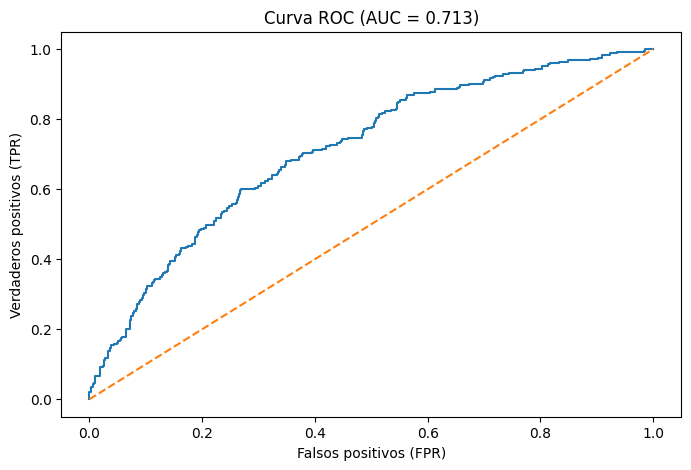

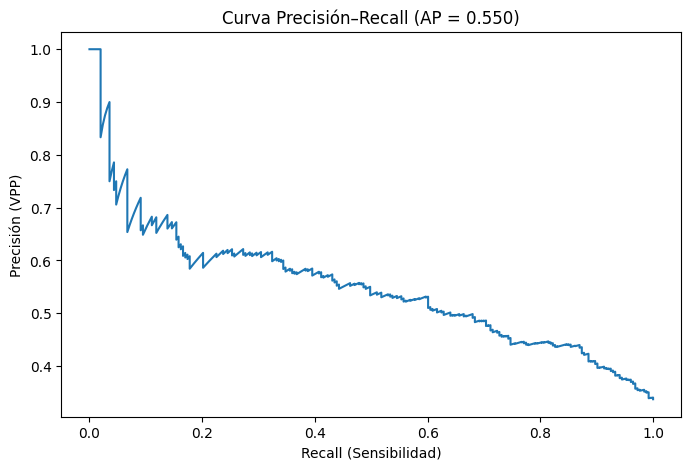

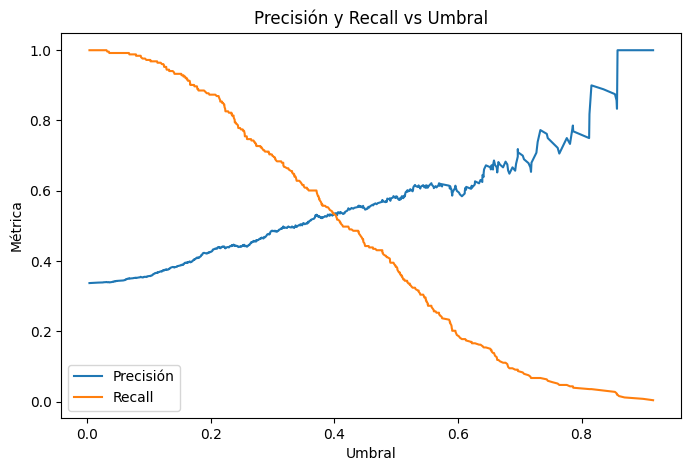

In [15]:

# --- Curva ROC ---
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Falsos positivos (FPR)")
plt.ylabel("Verdaderos positivos (TPR)")
plt.title(f"Curva ROC (AUC = {roc_auc:.3f})")
plt.show()

# --- Curva Precisión–Recall ---
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión (VPP)")
plt.title(f"Curva Precisión–Recall (AP = {ap:.3f})")
plt.show()

# --- Precisión y Recall vs Umbral ---
plt.figure()
plt.plot(pr_thresholds, precision[:-1], label="Precisión")
plt.plot(pr_thresholds, recall[:-1], label="Recall")
plt.xlabel("Umbral")
plt.ylabel("Métrica")
plt.title("Precisión y Recall vs Umbral")
plt.legend()
plt.show()



## 6) Comparar umbrales de referencia *(0.3 / 0.5 / 0.7)*

- Este cuadro muestra cómo cambian **TP/FP/TN/FN, Precisión, Recall y F1** al mover el umbral.  
- Útil para ilustrar el **trade-off**: *umbral bajo → más recall (menos FN) / umbral alto → más precisión (menos FP)*.


In [16]:

def evaluar_en_umbral(y_true, y_score, th):
    """Devuelve métricas y matriz de confusión al aplicar un umbral específico."""
    y_pred = (y_score >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {
        "umbral": th, "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "precision": prec, "recall": rec, "f1": f1
    }

umbrales_demo = [0.3, 0.5, 0.7]
pd.DataFrame([evaluar_en_umbral(y_test, y_scores, th) for th in umbrales_demo])


,umbral,TP,FP,TN,FN,precision,recall,f1
0,0.3,176,187,310,77,0.484848,0.695652,0.571429
1,0.5,97,69,428,156,0.584337,0.383399,0.463007
2,0.7,21,9,488,232,0.700000,0.083004,0.148410



## 7) Optimización por **costos** para elegir el **umbral óptimo**

- **C_FP** (*False Positive*): costo de **actuar** cuando el cliente **no* iba a abandonar (contacto innecesario, descuento mal aplicado, etc.).  
- **C_FN** (*False Negative*): costo de **no actuar** cuando el cliente **sí** abandona (pérdida del cliente/ingresos).  

> **Regla**: si **C_FN** es mucho mayor, conviene bajar el umbral (captar más casos, aunque suban los FP).  
> si **C_FP** es mayor, conviene subir el umbral (ser más selectivos).


Mejor umbral por costo = 0.124, costo total = 23550


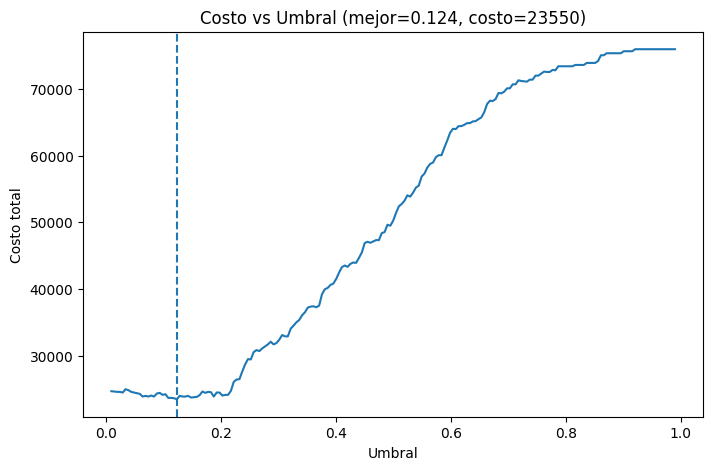

,umbral,FP,FN,costo_total,precision,recall,f1
23,0.123838,405,11,23550,0.374034,0.956522,0.537778
22,0.118889,414,10,23700,0.369863,0.960474,0.534066
20,0.108990,427,8,23750,0.364583,0.968379,0.529730
21,0.113939,421,9,23750,0.366917,0.964427,0.531590
28,0.148586,374,17,23800,0.386885,0.932806,0.546929


In [17]:

# Ajusta estos costos según tu caso de negocio
C_FP = 50    # costo de un Falso Positivo
C_FN = 300   # costo de un Falso Negativo

umbrales = np.linspace(0.01, 0.99, 199)
registros = []

for th in umbrales:
    y_pred = (y_scores >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    costo_total = C_FP * fp + C_FN * fn
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    registros.append([th, fp, fn, costo_total, prec, rec, f1])

costos_df = pd.DataFrame(registros, columns=["umbral","FP","FN","costo_total","precision","recall","f1"])
best_idx = costos_df["costo_total"].idxmin()
umbral_min_costo = float(costos_df.loc[best_idx, "umbral"])
costo_minimo = float(costos_df.loc[best_idx, "costo_total"])

print(f"Mejor umbral por costo = {umbral_min_costo:.3f}, costo total = {costo_minimo:.0f}")

# Gráfico costo vs umbral
plt.figure()
plt.plot(costos_df["umbral"], costos_df["costo_total"])
plt.axvline(umbral_min_costo, linestyle="--")
plt.xlabel("Umbral")
plt.ylabel("Costo total")
plt.title(f"Costo vs Umbral (mejor={umbral_min_costo:.3f}, costo={costo_minimo:.0f})")
plt.show()

# Top 5 umbrales con menor costo (útil para comparar alternativas cercanas)
costos_df.nsmallest(5, "costo_total")



## 8) Criterios alternativos: **Youden J** y **F1 máximo**

- **Youden J = TPR − FPR** (sobre la curva ROC): equilibrio entre sensibilidad y especificidad.  
- **F1 máximo**: balance entre precisión y recall; útil si quieres equilibrio entre ambos.  
- **Comparativo**: se muestran los resultados de Youden J, Mínimo Costo, F1 máximo y Umbral 0.5.


In [18]:

# Youden J = TPR - FPR
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
youden_vals = tpr - fpr
idx_j = int(np.argmax(youden_vals))
umbral_youden = float(roc_thresholds[idx_j])

# Umbral que maximiza F1 (búsqueda sobre la malla de umbrales)
f1_mejor, umbral_f1 = -1.0, 0.5
for th in umbrales:
    y_pred = (y_scores >= th).astype(int)
    f1_actual = f1_score(y_test, y_pred, zero_division=0)
    if f1_actual > f1_mejor:
        f1_mejor, umbral_f1 = f1_actual, float(th)

# Resumen comparativo de criterios
def resumen_umbral(criterio, umbral):
    r = evaluar_en_umbral(y_test, y_scores, umbral)
    r['criterio'] = criterio
    return r

resumen = pd.DataFrame([
    resumen_umbral("Youden_J", umbral_youden),
    resumen_umbral("Min_Costo", umbral_min_costo),
    resumen_umbral("F1_max", umbral_f1),
    resumen_umbral("Defecto_0.5", 0.5)
])[["criterio","umbral","TP","FP","TN","FN","precision","recall","f1"]]

resumen


,criterio,umbral,TP,FP,TN,FN,precision,recall,f1
0,Youden_J,0.317123,172,173,324,81,0.498551,0.679842,0.575251
1,Min_Costo,0.123838,242,405,92,11,0.374034,0.956522,0.537778
2,F1_max,0.212929,219,280,217,34,0.438878,0.865613,0.582447
3,Defecto_0.5,0.500000,97,69,428,156,0.584337,0.383399,0.463007



---

### ✔ Recomendaciones finales para clase
- Mueve **C_FP** y **C_FN** para crear distintos escenarios y discutir la **política de decisión**.  
- Evalúa el impacto de cambiar el **umbral** en términos operativos (¿tenemos capacidad para contactar a todos los positivos?).  
- Considera una **prueba piloto (A/B)** antes de adoptar un umbral en producción.

> Si necesitas una plantilla de **diapositivas** o **rúbrica de evaluación** asociada a este notebook, dímelo y la preparo.
